# Test `scfm_utils` Package

Verify that `load_scgpt_model`, `create_scgpt_dataset`, and `encode_scgpt_embeddings` produce the same results as the inline notebook code.

In [1]:
import warnings
import os

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

import scanpy as sc
from scgpt.utils import set_seed
from scfm_utils.scgpt import load_scgpt_model, create_scgpt_dataset, encode_scgpt_embeddings

set_seed(42)

## 1. Load model

In [2]:
bundle = load_scgpt_model("../models/scGPT_bc")

print(f"Model device: {next(bundle.model.parameters()).device}")
print(f"Vocab size: {len(bundle.vocab)}")
print(f"Gene2idx entries: {len(bundle.gene2idx)}")
print(f"Config: embsize={bundle.config['embsize']}, nlayers={bundle.config['nlayers']}")

Model device: cuda:0
Vocab size: 36574
Gene2idx entries: 36574
Config: embsize=512, nlayers=12


## 2. Create dataset

In [3]:
adata = sc.read("../data/Immune_ALL_human.h5ad", cache=True)
adata.obs["celltype"] = adata.obs["final_annotation"].astype(str)

ds = create_scgpt_dataset(
    adata,
    bundle.vocab,
    bundle.gene2idx,
    max_cells=10000,
)

print(f"Genes in vocab: {len(ds.genes_in_vocab)}")
print(f"DataLoader batches: {len(ds.dataloader)}")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...
Genes in vocab: 1173
DataLoader batches: 157


## 3. Encode embeddings

In [4]:
import numpy as np

cell_types = np.array(adata.obs["celltype"].values[:10000])
embs = encode_scgpt_embeddings(bundle.model, ds.dataloader, bundle.vocab, ds.genes_in_vocab, cell_types)

print(f"CLS embeddings shape: {embs.cls_embeddings.shape}")
print(f"Gene embeddings shape: {embs.gene_embeddings.shape}")
print(f"Gene names: {len(embs.gene_names)}")
print(f"Cell types: {embs.cell_types.shape}")

CLS embeddings shape: (10000, 512)
Gene embeddings shape: (10000, 1173, 512)
Gene names: 1173
Cell types: (10000,)


## 4. Sanity Check — UMAP of CLS embeddings

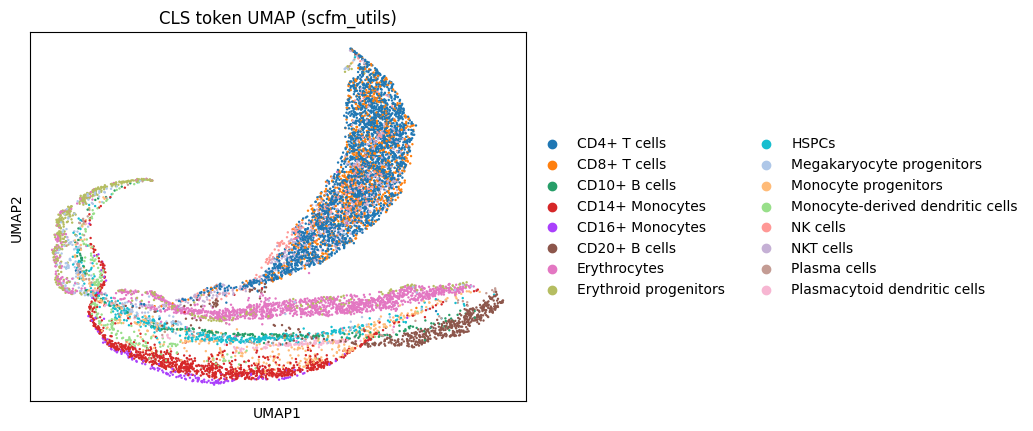

In [5]:
cls_adata = sc.AnnData(X=embs.cls_embeddings)
cls_adata.obs["celltype"] = adata.obs["celltype"].values[:len(cls_adata)]

sc.pp.neighbors(cls_adata, use_rep="X")
sc.tl.umap(cls_adata)
sc.pl.umap(cls_adata, color="celltype", title="CLS token UMAP (scfm_utils)")

## 5. Sanity Check — UMAP of Average Gene Embeddings (Erythrocytes)

In [6]:
import plotly.express as px
import pandas as pd

avg_embs = embs.average_gene_embeddings()

selected_celltype = "Erythrocytes"
gene_adata = sc.AnnData(X=avg_embs[selected_celltype])
gene_adata.obs["gene"] = embs.gene_names

sc.pp.neighbors(gene_adata, use_rep="X")
sc.tl.umap(gene_adata)

umap_df = pd.DataFrame(gene_adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"])
umap_df["gene"] = embs.gene_names

fig = px.scatter(
    umap_df, x="UMAP1", y="UMAP2",
    hover_name="gene",
    title=f"Gene UMAP — {selected_celltype} (averaged over {(embs.cell_types == selected_celltype).sum()} cells)",
    width=900, height=700,
)
fig.update_traces(marker_size=4)
fig.show()

## 6. Train TRRUST Regulation Classifier (CD4+ T cells)

In [13]:
from scfm_utils.trrust import load_trrust_data, TRRClassifierModel, REGULATION_LABELS

trrust_data = load_trrust_data("../data/trrust_rawdata.human.tsv", embs)

# Filter to CD4+ T cells only
cell_type = "CD4+ T cells"
mask = trrust_data.cell_types == cell_type
tf_emb = trrust_data.tf_embeddings[mask]
tgt_emb = trrust_data.target_embeddings[mask]
labels = trrust_data.labels[mask]

print(f"Total TRRUST records: {len(trrust_data.records)}")
print(f"Filtered records (both genes in embeddings): {len(trrust_data.filtered_records)}")
print(f"Training samples for {cell_type}: {mask.sum()}")
for label_id, name in trrust_data.label_names.items():
    print(f"  {name}: {(labels == label_id).sum()}")

Total TRRUST records: 7582
Filtered records (both genes in embeddings): 356
Training samples for CD4+ T cells: 356
  Activation: 123
  Repression: 73
  Unknown: 160


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

tf_tensor = torch.from_numpy(tf_emb).float()
tgt_tensor = torch.from_numpy(tgt_emb).float()
label_tensor = torch.from_numpy(labels).long()

dataset = TensorDataset(tf_tensor, tgt_tensor, label_tensor)
n_train = int(0.8 * len(dataset))
n_test = len(dataset) - n_train
## TODO: distribute labels between train/test sets
train_ds, test_ds = random_split(dataset, [n_train, n_test])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Train: {n_train}, Test: {n_test}")

Train: 284, Test: 72


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embsize = tf_emb.shape[1]
classifier = TRRClassifierModel(embsize=embsize).to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(40):
    classifier.train()
    total_loss = 0
    for tf_b, tgt_b, lbl_b in train_loader:
        tf_b, tgt_b, lbl_b = tf_b.to(device), tgt_b.to(device), lbl_b.to(device)
        logits = classifier(tf_b, tgt_b)
        loss = criterion(logits, lbl_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(lbl_b)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}  loss={total_loss / n_train:.4f}")

Epoch  10  loss=19.8934
Epoch  20  loss=12.9967
Epoch  30  loss=4.9153
Epoch  40  loss=2.0408


In [16]:
from sklearn.metrics import classification_report

classifier.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for tf_b, tgt_b, lbl_b in test_loader:
        logits = classifier(tf_b.to(device), tgt_b.to(device))
        all_preds.append(logits.argmax(dim=1).cpu())
        all_labels.append(lbl_b)

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
target_names = [trrust_data.label_names[i] for i in range(3)]
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

  Activation       0.33      0.04      0.08        23
  Repression       0.44      0.24      0.31        17
     Unknown       0.48      0.91      0.63        32

    accuracy                           0.47        72
   macro avg       0.42      0.40      0.34        72
weighted avg       0.43      0.47      0.38        72

